In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model, Sequential
from librosa import display
from tensorflow.keras import layers

from classic_generator import classic_generator
from spectrogram_class import spectrogram


In [2]:
tf.config.list_physical_devices('GPU')

2022-08-04 06:40:17.756346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 06:40:17.783000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 06:40:17.783431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
instrument_list = [1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

In [4]:
note_list = [21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]

# RNN-LSTM

In [5]:
def instrument_layer(inp, out_name):
    x = layers.LSTM(200)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(200, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    out1 = layers.Dense(16, activation = 'softmax', name = out_name)(x)
    return out1

In [6]:
def instrument_layer_simple(input, out_name):
    # out = layers.LSTM(len(note_list), return_sequences=True, 
    #                     dropout = 0.2, name = f"{out_name}")(input)

    inner = layers.TimeDistributed(layers.Flatten())(input)
    out = layers.TimeDistributed(layers.Dense(len(note_list)), 
                        name = out_name)(inner)
    return out

In [7]:
inp = layers.Input((None, 500), batch_size=32, )

out = layers.LSTM(len(note_list), return_sequences = True)(inp)

model_2conv_two_out = Model(inp, out)

2022-08-04 06:40:18.087857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 06:40:18.088743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 06:40:18.089744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 06:40:18.090678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

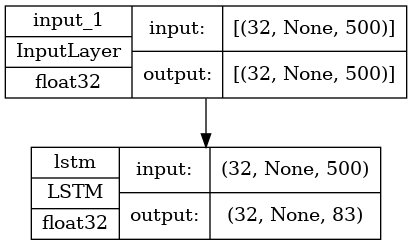

In [8]:
tf.keras.utils.plot_model(model_2conv_two_out , show_shapes=True, show_dtype=True)

In [9]:
instrument_list

[1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

In [10]:
from tensorflow.keras.backend import int_shape

inp = layers.Input((None, 64, 1), batch_size=2)
normalizer = layers.BatchNormalization()(inp)

lstm = layers.ConvLSTM1D(20, 5, return_sequences = True, 
                kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(normalizer)

simple_lstm_model = Model(inp, [instrument_layer_simple(lstm, 
                                f"instrument_{ins}") for ins in instrument_list])
                            # [instrument_1, instrument_7, instrument_41, instrument_42, 
                            # instrument_43, instrument_44, instrument_61, 
                            # instrument_69, instrument_71, instrument_72,
                            # instrument_74])

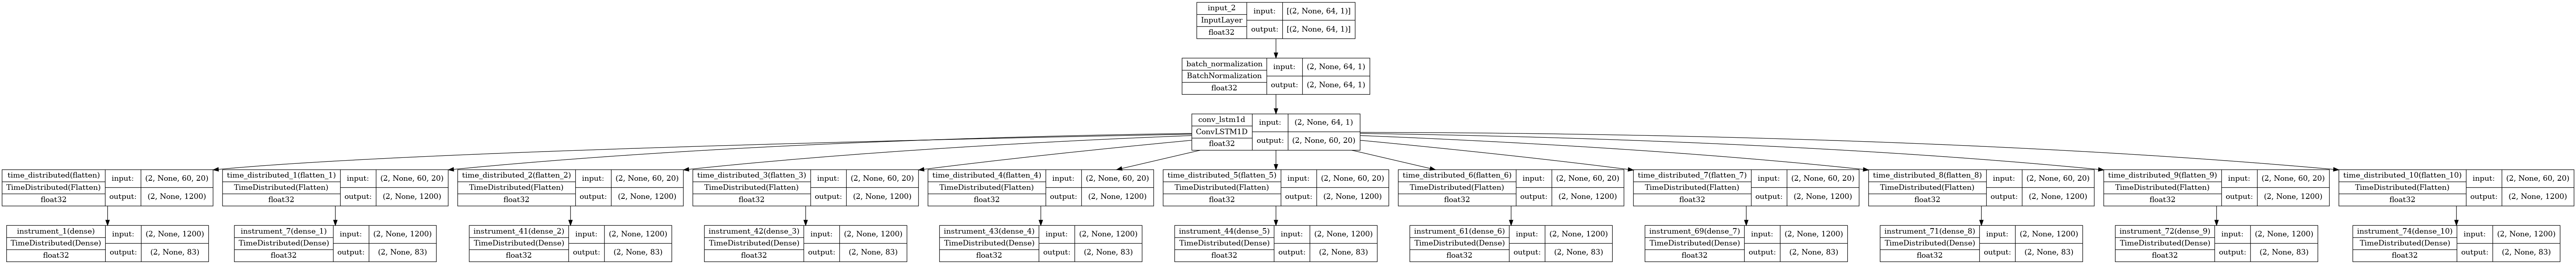

In [11]:

tf.keras.utils.plot_model(simple_lstm_model , show_shapes=True, show_dtype=True)

In [12]:
classic_train_generator = classic_generator(mode='train', batch_size=2)
                    
classic_eval_generator = classic_generator(mode = 'test', batch_size=2)

In [13]:

simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss={f"instrument_{ins}": tf.keras.losses.BinaryCrossentropy() 
                            for ins in instrument_list},
              metrics=['accuracy'])

In [14]:
!ls -dt $PWD/../models/classic_lstm/*

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_06_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_05_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_04_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_03_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_02_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_01_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_153555_01_classic_lstm
/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_151254_01_classic_lstm
/home/shiya/Documents/mu

In [15]:
newest_ckpt = !ls -dt $PWD/../models/classic_lstm/* | head -1
newest_ckpt = newest_ckpt[1]
newest_ckpt

'/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_195715_06_classic_lstm'

In [16]:
# simple_lstm_model = tf.keras.models.load_model('/home/shiya/Documents/music_transcription/notebooks/../models/classic_lstm/20220803_153555_01_classic_lstm')

In [17]:
simple_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(2, None, 64, 1)]   0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (2, None, 64, 1)    4           ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (2, None, 60, 20)    8480        ['batch_normalization[0][0]']    
                                                                                                  
 time_distributed (TimeDistribu  (2, None, 1200)     0           ['conv_lstm1d[0][0]']      

In [18]:
from datetime import datetime
from logging import warning
import warnings

warnings.filterwarnings('once', message='Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.')

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/classic__convlstm/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_classic_convlstm", 
                                                    monitor='val_accuracy',
                                                    save_freq = 'epoch')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

with warnings.catch_warnings():
    warnings.filterwarnings(
        action='ignore',
        module= 'numba')
    
    simple_lstm_history = simple_lstm_model.fit(classic_train_generator, epochs= 10, 
                                                validation_data= classic_eval_generator, 
                                                validation_freq=1, 
                                                use_multiprocessing= True,
                                                workers= 3, 
                                                verbose= 1, 
                                                callbacks=[ckpt_callback])

Epoch 1/10


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

  1/160 [..............................] - ETA: 2:08:25 - loss: 0.7657 - instrument_1_loss: 0.0303 - instrument_7_loss: 0.0280 - instrument_41_loss: 0.1235 - instrument_42_loss: 0.0924 - instrument_43_loss: 0.0814 - instrument_44_loss: 0.0280 - instrument_61_loss: 0.0285 - instrument_69_loss: 0.0258 - instrument_71_loss: 0.0323 - instrument_72_loss: 0.0253 - instrument_74_loss: 0.0257 - instrument_1_accuracy: 0.0000e+00 - instrument_7_accuracy: 0.0000e+00 - instrument_41_accuracy: 0.0225 - instrument_42_accuracy: 0.0020 - instrument_43_accuracy: 0.0061 - instrument_44_accuracy: 0.0041 - instrument_61_accuracy: 7.7498e-04 - instrument_69_accuracy: 0.0000e+00 - instrument_71_accuracy: 0.0012 - instrument_72_accuracy: 2.8181e-04 - instrument_74_accuracy: 0.0063

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  2/160 [..............................] - ETA: 37:13 - loss: 1.7058 - instrument_1_loss: 0.1682 - instrument_7_loss: 0.1264 - instrument_41_loss: 0.1509 - instrument_42_loss: 0.1458 - instrument_43_loss: 0.1354 - instrument_44_loss: 0.1293 - instrument_61_loss: 0.1273 - instrument_69_loss: 0.1262 - instrument_71_loss: 0.1290 - instrument_72_loss: 0.1225 - instrument_74_loss: 0.1266 - instrument_1_accuracy: 0.0025 - instrument_7_accuracy: 4.3167e-05 - instrument_41_accuracy: 0.0138 - instrument_42_accuracy: 0.0015 - instrument_43_accuracy: 0.0038 - instrument_44_accuracy: 0.0025 - instrument_61_accuracy: 4.7483e-04 - instrument_69_accuracy: 0.0000e+00 - instrument_71_accuracy: 7.3383e-04 - instrument_72_accuracy: 5.1800e-04 - instrument_74_accuracy: 0.0053  

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  3/160 [..............................] - ETA: 45:38 - loss: 1.5693 - instrument_1_loss: 0.2102 - instrument_7_loss: 0.1104 - instrument_41_loss: 0.1389 - instrument_42_loss: 0.1230 - instrument_43_loss: 0.1151 - instrument_44_loss: 0.1124 - instrument_61_loss: 0.1111 - instrument_69_loss: 0.1106 - instrument_71_loss: 0.1118 - instrument_72_loss: 0.1065 - instrument_74_loss: 0.1113 - instrument_1_accuracy: 0.0065 - instrument_7_accuracy: 2.7701e-05 - instrument_41_accuracy: 0.0089 - instrument_42_accuracy: 9.4183e-04 - instrument_43_accuracy: 0.0030 - instrument_44_accuracy: 0.0017 - instrument_61_accuracy: 3.0471e-04 - instrument_69_accuracy: 0.0000e+00 - instrument_71_accuracy: 4.7091e-04 - instrument_72_accuracy: 0.0089 - instrument_74_accuracy: 0.0035

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  4/160 [..............................] - ETA: 38:41 - loss: 1.3073 - instrument_1_loss: 0.2075 - instrument_7_loss: 0.0829 - instrument_41_loss: 0.1172 - instrument_42_loss: 0.1033 - instrument_43_loss: 0.0966 - instrument_44_loss: 0.0844 - instrument_61_loss: 0.0834 - instrument_69_loss: 0.0830 - instrument_71_loss: 0.0839 - instrument_72_loss: 0.0800 - instrument_74_loss: 0.0835 - instrument_1_accuracy: 0.0077 - instrument_7_accuracy: 4.7165e-05 - instrument_41_accuracy: 0.0090 - instrument_42_accuracy: 0.0014 - instrument_43_accuracy: 0.0039 - instrument_44_accuracy: 0.0014 - instrument_61_accuracy: 2.5941e-04 - instrument_69_accuracy: 0.0025 - instrument_71_accuracy: 4.0091e-04 - instrument_72_accuracy: 0.0076 - instrument_74_accuracy: 0.0029        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  5/160 [..............................] - ETA: 38:38 - loss: 1.1592 - instrument_1_loss: 0.2418 - instrument_7_loss: 0.0663 - instrument_41_loss: 0.0943 - instrument_42_loss: 0.0828 - instrument_43_loss: 0.0778 - instrument_44_loss: 0.0675 - instrument_61_loss: 0.0667 - instrument_69_loss: 0.0664 - instrument_71_loss: 0.0671 - instrument_72_loss: 0.0640 - instrument_74_loss: 0.0668 - instrument_1_accuracy: 0.0084 - instrument_7_accuracy: 0.0224 - instrument_41_accuracy: 0.0075 - instrument_42_accuracy: 0.0011 - instrument_43_accuracy: 0.0032 - instrument_44_accuracy: 0.0012 - instrument_61_accuracy: 2.1088e-04 - instrument_69_accuracy: 0.0753 - instrument_71_accuracy: 3.2591e-04 - instrument_72_accuracy: 0.0062 - instrument_74_accuracy: 0.0024    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  6/160 [>.............................] - ETA: 38:53 - loss: 1.0782 - instrument_1_loss: 0.2517 - instrument_7_loss: 0.0553 - instrument_41_loss: 0.0866 - instrument_42_loss: 0.0695 - instrument_43_loss: 0.0883 - instrument_44_loss: 0.0563 - instrument_61_loss: 0.0556 - instrument_69_loss: 0.0554 - instrument_71_loss: 0.0560 - instrument_72_loss: 0.0534 - instrument_74_loss: 0.0557 - instrument_1_accuracy: 0.0102 - instrument_7_accuracy: 0.0244 - instrument_41_accuracy: 0.0076 - instrument_42_accuracy: 9.3642e-04 - instrument_43_accuracy: 0.0047 - instrument_44_accuracy: 9.6871e-04 - instrument_61_accuracy: 1.7760e-04 - instrument_69_accuracy: 0.0752 - instrument_71_accuracy: 2.7447e-04 - instrument_72_accuracy: 0.0052 - instrument_74_accuracy: 0.0020

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  7/160 [>.............................] - ETA: 47:13 - loss: 1.0355 - instrument_1_loss: 0.2570 - instrument_7_loss: 0.0474 - instrument_41_loss: 0.0974 - instrument_42_loss: 0.0707 - instrument_43_loss: 0.0863 - instrument_44_loss: 0.0483 - instrument_61_loss: 0.0477 - instrument_69_loss: 0.0475 - instrument_71_loss: 0.0480 - instrument_72_loss: 0.0458 - instrument_74_loss: 0.0478 - instrument_1_accuracy: 0.0101 - instrument_7_accuracy: 0.0233 - instrument_41_accuracy: 0.0242 - instrument_42_accuracy: 0.0048 - instrument_43_accuracy: 0.0062 - instrument_44_accuracy: 7.4779e-04 - instrument_61_accuracy: 1.3710e-04 - instrument_69_accuracy: 0.0768 - instrument_71_accuracy: 2.1187e-04 - instrument_72_accuracy: 0.0040 - instrument_74_accuracy: 0.0016    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  8/160 [>.............................] - ETA: 49:14 - loss: 0.9832 - instrument_1_loss: 0.2691 - instrument_7_loss: 0.0415 - instrument_41_loss: 0.0948 - instrument_42_loss: 0.0632 - instrument_43_loss: 0.0766 - instrument_44_loss: 0.0422 - instrument_61_loss: 0.0417 - instrument_69_loss: 0.0416 - instrument_71_loss: 0.0420 - instrument_72_loss: 0.0401 - instrument_74_loss: 0.0418 - instrument_1_accuracy: 0.0131 - instrument_7_accuracy: 0.0203 - instrument_41_accuracy: 0.0217 - instrument_42_accuracy: 0.0041 - instrument_43_accuracy: 0.0052 - instrument_44_accuracy: 6.3559e-04 - instrument_61_accuracy: 1.1653e-04 - instrument_69_accuracy: 0.0978 - instrument_71_accuracy: 1.8008e-04 - instrument_72_accuracy: 0.0034 - instrument_74_accuracy: 0.0013

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


  9/160 [>.............................] - ETA: 48:53 - loss: 0.9153 - instrument_1_loss: 0.2396 - instrument_7_loss: 0.0369 - instrument_41_loss: 0.0941 - instrument_42_loss: 0.0585 - instrument_43_loss: 0.0788 - instrument_44_loss: 0.0376 - instrument_61_loss: 0.0371 - instrument_69_loss: 0.0370 - instrument_71_loss: 0.0374 - instrument_72_loss: 0.0357 - instrument_74_loss: 0.0372 - instrument_1_accuracy: 0.0116 - instrument_7_accuracy: 0.0182 - instrument_41_accuracy: 0.0209 - instrument_42_accuracy: 0.0036 - instrument_43_accuracy: 0.0077 - instrument_44_accuracy: 5.6588e-04 - instrument_61_accuracy: 1.6976e-04 - instrument_69_accuracy: 0.1560 - instrument_71_accuracy: 1.6033e-04 - instrument_72_accuracy: 0.0030 - instrument_74_accuracy: 0.0012

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 10/160 [>.............................] - ETA: 48:27 - loss: 0.8920 - instrument_1_loss: 0.2341 - instrument_7_loss: 0.0332 - instrument_41_loss: 0.1026 - instrument_42_loss: 0.0612 - instrument_43_loss: 0.0789 - instrument_44_loss: 0.0338 - instrument_61_loss: 0.0334 - instrument_69_loss: 0.0333 - instrument_71_loss: 0.0336 - instrument_72_loss: 0.0321 - instrument_74_loss: 0.0335 - instrument_1_accuracy: 0.0117 - instrument_7_accuracy: 0.0168 - instrument_41_accuracy: 0.0194 - instrument_42_accuracy: 0.0036 - instrument_43_accuracy: 0.0078 - instrument_44_accuracy: 5.1479e-04 - instrument_61_accuracy: 1.5444e-04 - instrument_69_accuracy: 0.1421 - instrument_71_accuracy: 1.4586e-04 - instrument_72_accuracy: 0.0028 - instrument_74_accuracy: 0.0011

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 11/160 [=>............................] - ETA: 50:27 - loss: 0.8610 - instrument_1_loss: 0.2472 - instrument_7_loss: 0.0302 - instrument_41_loss: 0.0948 - instrument_42_loss: 0.0561 - instrument_43_loss: 0.0720 - instrument_44_loss: 0.0307 - instrument_61_loss: 0.0304 - instrument_69_loss: 0.0303 - instrument_71_loss: 0.0306 - instrument_72_loss: 0.0292 - instrument_74_loss: 0.0304 - instrument_1_accuracy: 0.0118 - instrument_7_accuracy: 0.0149 - instrument_41_accuracy: 0.0170 - instrument_42_accuracy: 0.0032 - instrument_43_accuracy: 0.0068 - instrument_44_accuracy: 4.5088e-04 - instrument_61_accuracy: 1.3526e-04 - instrument_69_accuracy: 0.1245 - instrument_71_accuracy: 1.2775e-04 - instrument_72_accuracy: 0.0024 - instrument_74_accuracy: 9.3933e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 12/160 [=>............................] - ETA: 49:34 - loss: 0.8415 - instrument_1_loss: 0.2594 - instrument_7_loss: 0.0279 - instrument_41_loss: 0.0906 - instrument_42_loss: 0.0520 - instrument_43_loss: 0.0683 - instrument_44_loss: 0.0283 - instrument_61_loss: 0.0280 - instrument_69_loss: 0.0279 - instrument_71_loss: 0.0283 - instrument_72_loss: 0.0270 - instrument_74_loss: 0.0280 - instrument_1_accuracy: 0.0122 - instrument_7_accuracy: 0.0142 - instrument_41_accuracy: 0.0161 - instrument_42_accuracy: 0.0029 - instrument_43_accuracy: 0.0064 - instrument_44_accuracy: 5.1319e-04 - instrument_61_accuracy: 1.2483e-04 - instrument_69_accuracy: 0.1149 - instrument_71_accuracy: 1.1790e-04 - instrument_72_accuracy: 0.0022 - instrument_74_accuracy: 8.6688e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 13/160 [=>............................] - ETA: 48:51 - loss: 0.8171 - instrument_1_loss: 0.2692 - instrument_7_loss: 0.0257 - instrument_41_loss: 0.0839 - instrument_42_loss: 0.0481 - instrument_43_loss: 0.0631 - instrument_44_loss: 0.0261 - instrument_61_loss: 0.0258 - instrument_69_loss: 0.0258 - instrument_71_loss: 0.0261 - instrument_72_loss: 0.0249 - instrument_74_loss: 0.0259 - instrument_1_accuracy: 0.0127 - instrument_7_accuracy: 0.0133 - instrument_41_accuracy: 0.0151 - instrument_42_accuracy: 0.0027 - instrument_43_accuracy: 0.0059 - instrument_44_accuracy: 4.7880e-04 - instrument_61_accuracy: 1.2294e-04 - instrument_69_accuracy: 0.1072 - instrument_71_accuracy: 1.1000e-04 - instrument_72_accuracy: 0.0021 - instrument_74_accuracy: 8.0879e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 14/160 [=>............................] - ETA: 48:55 - loss: 0.7902 - instrument_1_loss: 0.2620 - instrument_7_loss: 0.0239 - instrument_41_loss: 0.0780 - instrument_42_loss: 0.0447 - instrument_43_loss: 0.0688 - instrument_44_loss: 0.0243 - instrument_61_loss: 0.0240 - instrument_69_loss: 0.0239 - instrument_71_loss: 0.0242 - instrument_72_loss: 0.0231 - instrument_74_loss: 0.0240 - instrument_1_accuracy: 0.0119 - instrument_7_accuracy: 0.0123 - instrument_41_accuracy: 0.0139 - instrument_42_accuracy: 0.0025 - instrument_43_accuracy: 0.0056 - instrument_44_accuracy: 4.4238e-04 - instrument_61_accuracy: 1.1358e-04 - instrument_69_accuracy: 0.0993 - instrument_71_accuracy: 1.0163e-04 - instrument_72_accuracy: 0.0019 - instrument_74_accuracy: 8.1303e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 15/160 [=>............................] - ETA: 49:03 - loss: 0.7673 - instrument_1_loss: 0.2587 - instrument_7_loss: 0.0223 - instrument_41_loss: 0.0766 - instrument_42_loss: 0.0436 - instrument_43_loss: 0.0661 - instrument_44_loss: 0.0227 - instrument_61_loss: 0.0224 - instrument_69_loss: 0.0223 - instrument_71_loss: 0.0226 - instrument_72_loss: 0.0216 - instrument_74_loss: 0.0224 - instrument_1_accuracy: 0.0123 - instrument_7_accuracy: 0.0114 - instrument_41_accuracy: 0.0135 - instrument_42_accuracy: 0.0026 - instrument_43_accuracy: 0.0052 - instrument_44_accuracy: 4.1085e-04 - instrument_61_accuracy: 1.0549e-04 - instrument_69_accuracy: 0.0922 - instrument_71_accuracy: 9.4384e-05 - instrument_72_accuracy: 0.0018 - instrument_74_accuracy: 7.5507e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 16/160 [==>...........................] - ETA: 48:43 - loss: 0.7645 - instrument_1_loss: 0.2429 - instrument_7_loss: 0.0209 - instrument_41_loss: 0.0904 - instrument_42_loss: 0.0509 - instrument_43_loss: 0.0709 - instrument_44_loss: 0.0212 - instrument_61_loss: 0.0210 - instrument_69_loss: 0.0209 - instrument_71_loss: 0.0212 - instrument_72_loss: 0.0202 - instrument_74_loss: 0.0210 - instrument_1_accuracy: 0.0116 - instrument_7_accuracy: 0.0107 - instrument_41_accuracy: 0.0146 - instrument_42_accuracy: 0.0027 - instrument_43_accuracy: 0.0053 - instrument_44_accuracy: 3.8729e-04 - instrument_61_accuracy: 9.9440e-05 - instrument_69_accuracy: 0.0869 - instrument_71_accuracy: 8.8973e-05 - instrument_72_accuracy: 0.0017 - instrument_74_accuracy: 7.1178e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 17/160 [==>...........................] - ETA: 48:29 - loss: 0.7580 - instrument_1_loss: 0.2448 - instrument_7_loss: 0.0304 - instrument_41_loss: 0.0900 - instrument_42_loss: 0.0479 - instrument_43_loss: 0.0667 - instrument_44_loss: 0.0200 - instrument_61_loss: 0.0198 - instrument_69_loss: 0.0197 - instrument_71_loss: 0.0200 - instrument_72_loss: 0.0190 - instrument_74_loss: 0.0198 - instrument_1_accuracy: 0.0125 - instrument_7_accuracy: 0.0101 - instrument_41_accuracy: 0.0147 - instrument_42_accuracy: 0.0025 - instrument_43_accuracy: 0.0050 - instrument_44_accuracy: 3.6440e-04 - instrument_61_accuracy: 9.3562e-05 - instrument_69_accuracy: 0.0818 - instrument_71_accuracy: 8.3713e-05 - instrument_72_accuracy: 0.0016 - instrument_74_accuracy: 6.6971e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 18/160 [==>...........................] - ETA: 49:15 - loss: 0.8065 - instrument_1_loss: 0.2523 - instrument_7_loss: 0.0334 - instrument_41_loss: 0.0988 - instrument_42_loss: 0.0536 - instrument_43_loss: 0.0712 - instrument_44_loss: 0.0229 - instrument_61_loss: 0.0228 - instrument_69_loss: 0.0227 - instrument_71_loss: 0.0243 - instrument_72_loss: 0.0243 - instrument_74_loss: 0.0231 - instrument_1_accuracy: 0.0146 - instrument_7_accuracy: 0.0095 - instrument_41_accuracy: 0.0139 - instrument_42_accuracy: 0.0023 - instrument_43_accuracy: 0.0046 - instrument_44_accuracy: 3.4747e-04 - instrument_61_accuracy: 8.6868e-05 - instrument_69_accuracy: 0.0762 - instrument_71_accuracy: 7.7724e-05 - instrument_72_accuracy: 0.0015 - instrument_74_accuracy: 6.2179e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 19/160 [==>...........................] - ETA: 48:46 - loss: 0.8104 - instrument_1_loss: 0.2682 - instrument_7_loss: 0.0318 - instrument_41_loss: 0.0990 - instrument_42_loss: 0.0541 - instrument_43_loss: 0.0688 - instrument_44_loss: 0.0218 - instrument_61_loss: 0.0217 - instrument_69_loss: 0.0216 - instrument_71_loss: 0.0231 - instrument_72_loss: 0.0231 - instrument_74_loss: 0.0220 - instrument_1_accuracy: 0.0149 - instrument_7_accuracy: 0.0090 - instrument_41_accuracy: 0.0137 - instrument_42_accuracy: 0.0026 - instrument_43_accuracy: 0.0045 - instrument_44_accuracy: 0.0122 - instrument_61_accuracy: 8.2614e-05 - instrument_69_accuracy: 0.0731 - instrument_71_accuracy: 7.3918e-05 - instrument_72_accuracy: 0.0014 - instrument_74_accuracy: 5.9134e-04    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 20/160 [==>...........................] - ETA: 47:42 - loss: 0.9018 - instrument_1_loss: 0.2784 - instrument_7_loss: 0.0355 - instrument_41_loss: 0.1184 - instrument_42_loss: 0.0665 - instrument_43_loss: 0.0750 - instrument_44_loss: 0.0285 - instrument_61_loss: 0.0272 - instrument_69_loss: 0.0259 - instrument_71_loss: 0.0297 - instrument_72_loss: 0.0318 - instrument_74_loss: 0.0294 - instrument_1_accuracy: 0.0147 - instrument_7_accuracy: 0.0087 - instrument_41_accuracy: 0.0132 - instrument_42_accuracy: 0.0025 - instrument_43_accuracy: 0.0044 - instrument_44_accuracy: 0.0122 - instrument_61_accuracy: 7.9631e-05 - instrument_69_accuracy: 0.0706 - instrument_71_accuracy: 8.3822e-05 - instrument_72_accuracy: 0.0014 - instrument_74_accuracy: 7.0830e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 21/160 [==>...........................] - ETA: 48:38 - loss: 2.1808 - instrument_1_loss: 0.3657 - instrument_7_loss: 0.1567 - instrument_41_loss: 0.2492 - instrument_42_loss: 0.1865 - instrument_43_loss: 0.1875 - instrument_44_loss: 0.1373 - instrument_61_loss: 0.1531 - instrument_69_loss: 0.1617 - instrument_71_loss: 0.1386 - instrument_72_loss: 0.1539 - instrument_74_loss: 0.1345 - instrument_1_accuracy: 0.0163 - instrument_7_accuracy: 0.0328 - instrument_41_accuracy: 0.0197 - instrument_42_accuracy: 0.0031 - instrument_43_accuracy: 0.0047 - instrument_44_accuracy: 0.0114 - instrument_61_accuracy: 1.3639e-04 - instrument_69_accuracy: 0.0657 - instrument_71_accuracy: 7.7937e-05 - instrument_72_accuracy: 0.0013 - instrument_74_accuracy: 6.5857e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 22/160 [===>..........................] - ETA: 48:46 - loss: 2.6481 - instrument_1_loss: 0.4045 - instrument_7_loss: 0.1941 - instrument_41_loss: 0.3216 - instrument_42_loss: 0.2404 - instrument_43_loss: 0.2342 - instrument_44_loss: 0.1753 - instrument_61_loss: 0.1864 - instrument_69_loss: 0.1952 - instrument_71_loss: 0.1733 - instrument_72_loss: 0.1983 - instrument_74_loss: 0.1673 - instrument_1_accuracy: 0.0165 - instrument_7_accuracy: 0.0330 - instrument_41_accuracy: 0.0186 - instrument_42_accuracy: 0.0029 - instrument_43_accuracy: 0.0044 - instrument_44_accuracy: 0.0109 - instrument_61_accuracy: 1.2930e-04 - instrument_69_accuracy: 0.0623 - instrument_71_accuracy: 7.3884e-05 - instrument_72_accuracy: 0.0012 - instrument_74_accuracy: 6.2432e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 23/160 [===>..........................] - ETA: 47:36 - loss: 2.7542 - instrument_1_loss: 0.4001 - instrument_7_loss: 0.1991 - instrument_41_loss: 0.3568 - instrument_42_loss: 0.2640 - instrument_43_loss: 0.2462 - instrument_44_loss: 0.1836 - instrument_61_loss: 0.1899 - instrument_69_loss: 0.1962 - instrument_71_loss: 0.1809 - instrument_72_loss: 0.2061 - instrument_74_loss: 0.1717 - instrument_1_accuracy: 0.0160 - instrument_7_accuracy: 0.0336 - instrument_41_accuracy: 0.0188 - instrument_42_accuracy: 0.0032 - instrument_43_accuracy: 0.0048 - instrument_44_accuracy: 0.0106 - instrument_61_accuracy: 1.2563e-04 - instrument_69_accuracy: 0.0626 - instrument_71_accuracy: 7.1790e-05 - instrument_72_accuracy: 0.0012 - instrument_74_accuracy: 6.0663e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 24/160 [===>..........................] - ETA: 47:59 - loss: 2.9019 - instrument_1_loss: 0.3939 - instrument_7_loss: 0.1940 - instrument_41_loss: 0.4468 - instrument_42_loss: 0.3152 - instrument_43_loss: 0.2973 - instrument_44_loss: 0.1768 - instrument_61_loss: 0.1830 - instrument_69_loss: 0.1888 - instrument_71_loss: 0.1747 - instrument_72_loss: 0.2034 - instrument_74_loss: 0.1653 - instrument_1_accuracy: 0.0165 - instrument_7_accuracy: 0.0319 - instrument_41_accuracy: 0.0202 - instrument_42_accuracy: 0.0036 - instrument_43_accuracy: 0.0048 - instrument_44_accuracy: 0.0100 - instrument_61_accuracy: 1.1936e-04 - instrument_69_accuracy: 0.1030 - instrument_71_accuracy: 6.8204e-05 - instrument_72_accuracy: 0.0011 - instrument_74_accuracy: 5.7632e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 25/160 [===>..........................] - ETA: 47:35 - loss: 2.9126 - instrument_1_loss: 0.3971 - instrument_7_loss: 0.1868 - instrument_41_loss: 0.4771 - instrument_42_loss: 0.3370 - instrument_43_loss: 0.2961 - instrument_44_loss: 0.1703 - instrument_61_loss: 0.1763 - instrument_69_loss: 0.1818 - instrument_71_loss: 0.1682 - instrument_72_loss: 0.1959 - instrument_74_loss: 0.1593 - instrument_1_accuracy: 0.0159 - instrument_7_accuracy: 0.0308 - instrument_41_accuracy: 0.0206 - instrument_42_accuracy: 0.0035 - instrument_43_accuracy: 0.0046 - instrument_44_accuracy: 0.0097 - instrument_61_accuracy: 1.1518e-04 - instrument_69_accuracy: 0.0994 - instrument_71_accuracy: 6.5817e-05 - instrument_72_accuracy: 0.0011 - instrument_74_accuracy: 5.5616e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 26/160 [===>..........................] - ETA: 48:42 - loss: 3.2532 - instrument_1_loss: 0.4088 - instrument_7_loss: 0.1888 - instrument_41_loss: 0.6074 - instrument_42_loss: 0.4101 - instrument_43_loss: 0.3847 - instrument_44_loss: 0.1735 - instrument_61_loss: 0.1824 - instrument_69_loss: 0.1932 - instrument_71_loss: 0.1685 - instrument_72_loss: 0.2036 - instrument_74_loss: 0.1610 - instrument_1_accuracy: 0.0149 - instrument_7_accuracy: 0.0290 - instrument_41_accuracy: 0.0196 - instrument_42_accuracy: 0.0036 - instrument_43_accuracy: 0.0046 - instrument_44_accuracy: 0.0091 - instrument_61_accuracy: 1.0826e-04 - instrument_69_accuracy: 0.0934 - instrument_71_accuracy: 6.1863e-05 - instrument_72_accuracy: 0.0010 - instrument_74_accuracy: 5.2274e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 27/160 [====>.........................] - ETA: 48:46 - loss: 3.5039 - instrument_1_loss: 0.4078 - instrument_7_loss: 0.1913 - instrument_41_loss: 0.7020 - instrument_42_loss: 0.4736 - instrument_43_loss: 0.4596 - instrument_44_loss: 0.1694 - instrument_61_loss: 0.1885 - instrument_69_loss: 0.1986 - instrument_71_loss: 0.1738 - instrument_72_loss: 0.2058 - instrument_74_loss: 0.1569 - instrument_1_accuracy: 0.0143 - instrument_7_accuracy: 0.0277 - instrument_41_accuracy: 0.0199 - instrument_42_accuracy: 0.0042 - instrument_43_accuracy: 0.0053 - instrument_44_accuracy: 0.0087 - instrument_61_accuracy: 1.0333e-04 - instrument_69_accuracy: 0.0892 - instrument_71_accuracy: 6.1995e-05 - instrument_72_accuracy: 9.8602e-04 - instrument_74_accuracy: 4.9891e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 28/160 [====>.........................] - ETA: 48:57 - loss: 3.6048 - instrument_1_loss: 0.3998 - instrument_7_loss: 0.1910 - instrument_41_loss: 0.7670 - instrument_42_loss: 0.5096 - instrument_43_loss: 0.4878 - instrument_44_loss: 0.1633 - instrument_61_loss: 0.1822 - instrument_69_loss: 0.1980 - instrument_71_loss: 0.1676 - instrument_72_loss: 0.2048 - instrument_74_loss: 0.1513 - instrument_1_accuracy: 0.0136 - instrument_7_accuracy: 0.0265 - instrument_41_accuracy: 0.0196 - instrument_42_accuracy: 0.0056 - instrument_43_accuracy: 0.0051 - instrument_44_accuracy: 0.0083 - instrument_61_accuracy: 9.8663e-05 - instrument_69_accuracy: 0.0851 - instrument_71_accuracy: 5.9198e-05 - instrument_72_accuracy: 9.4152e-04 - instrument_74_accuracy: 4.7640e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 29/160 [====>.........................] - ETA: 48:39 - loss: 3.6122 - instrument_1_loss: 0.4041 - instrument_7_loss: 0.1846 - instrument_41_loss: 0.7874 - instrument_42_loss: 0.5207 - instrument_43_loss: 0.4936 - instrument_44_loss: 0.1577 - instrument_61_loss: 0.1760 - instrument_69_loss: 0.1917 - instrument_71_loss: 0.1618 - instrument_72_loss: 0.2000 - instrument_74_loss: 0.1461 - instrument_1_accuracy: 0.0133 - instrument_7_accuracy: 0.0255 - instrument_41_accuracy: 0.0189 - instrument_42_accuracy: 0.0054 - instrument_43_accuracy: 0.0049 - instrument_44_accuracy: 0.0080 - instrument_61_accuracy: 9.5231e-05 - instrument_69_accuracy: 0.0822 - instrument_71_accuracy: 5.7139e-05 - instrument_72_accuracy: 0.0016 - instrument_74_accuracy: 4.5983e-04    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 30/160 [====>.........................] - ETA: 48:11 - loss: 3.5858 - instrument_1_loss: 0.4029 - instrument_7_loss: 0.1785 - instrument_41_loss: 0.7991 - instrument_42_loss: 0.5244 - instrument_43_loss: 0.4870 - instrument_44_loss: 0.1524 - instrument_61_loss: 0.1701 - instrument_69_loss: 0.1853 - instrument_71_loss: 0.1564 - instrument_72_loss: 0.1933 - instrument_74_loss: 0.1412 - instrument_1_accuracy: 0.0129 - instrument_7_accuracy: 0.0248 - instrument_41_accuracy: 0.0186 - instrument_42_accuracy: 0.0057 - instrument_43_accuracy: 0.0050 - instrument_44_accuracy: 0.0078 - instrument_61_accuracy: 9.2316e-05 - instrument_69_accuracy: 0.0797 - instrument_71_accuracy: 5.5390e-05 - instrument_72_accuracy: 0.0015 - instrument_74_accuracy: 4.4576e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 31/160 [====>.........................] - ETA: 47:15 - loss: 3.5488 - instrument_1_loss: 0.3899 - instrument_7_loss: 0.1727 - instrument_41_loss: 0.8085 - instrument_42_loss: 0.5278 - instrument_43_loss: 0.4814 - instrument_44_loss: 0.1475 - instrument_61_loss: 0.1646 - instrument_69_loss: 0.1793 - instrument_71_loss: 0.1514 - instrument_72_loss: 0.1871 - instrument_74_loss: 0.1366 - instrument_1_accuracy: 0.0126 - instrument_7_accuracy: 0.0243 - instrument_41_accuracy: 0.0190 - instrument_42_accuracy: 0.0063 - instrument_43_accuracy: 0.0050 - instrument_44_accuracy: 0.0076 - instrument_61_accuracy: 9.0451e-05 - instrument_69_accuracy: 0.0780 - instrument_71_accuracy: 5.4271e-05 - instrument_72_accuracy: 0.0015 - instrument_74_accuracy: 4.3675e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 32/160 [=====>........................] - ETA: 46:04 - loss: 3.5168 - instrument_1_loss: 0.3837 - instrument_7_loss: 0.1673 - instrument_41_loss: 0.8157 - instrument_42_loss: 0.5303 - instrument_43_loss: 0.4745 - instrument_44_loss: 0.1429 - instrument_61_loss: 0.1595 - instrument_69_loss: 0.1737 - instrument_71_loss: 0.1466 - instrument_72_loss: 0.1813 - instrument_74_loss: 0.1324 - instrument_1_accuracy: 0.0125 - instrument_7_accuracy: 0.0239 - instrument_41_accuracy: 0.0192 - instrument_42_accuracy: 0.0064 - instrument_43_accuracy: 0.0049 - instrument_44_accuracy: 0.0075 - instrument_61_accuracy: 8.9206e-05 - instrument_69_accuracy: 0.0770 - instrument_71_accuracy: 5.3524e-05 - instrument_72_accuracy: 0.0015 - instrument_74_accuracy: 4.3074e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 33/160 [=====>........................] - ETA: 45:59 - loss: 3.4805 - instrument_1_loss: 0.3767 - instrument_7_loss: 0.1623 - instrument_41_loss: 0.8160 - instrument_42_loss: 0.5331 - instrument_43_loss: 0.4685 - instrument_44_loss: 0.1386 - instrument_61_loss: 0.1546 - instrument_69_loss: 0.1684 - instrument_71_loss: 0.1422 - instrument_72_loss: 0.1758 - instrument_74_loss: 0.1284 - instrument_1_accuracy: 0.0123 - instrument_7_accuracy: 0.0231 - instrument_41_accuracy: 0.0195 - instrument_42_accuracy: 0.0069 - instrument_43_accuracy: 0.0050 - instrument_44_accuracy: 0.0073 - instrument_61_accuracy: 8.6327e-05 - instrument_69_accuracy: 0.0745 - instrument_71_accuracy: 5.1796e-05 - instrument_72_accuracy: 0.0014 - instrument_74_accuracy: 4.1684e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


 34/160 [=====>........................] - ETA: 46:19 - loss: 3.4491 - instrument_1_loss: 0.3801 - instrument_7_loss: 0.1575 - instrument_41_loss: 0.8135 - instrument_42_loss: 0.5335 - instrument_43_loss: 0.4601 - instrument_44_loss: 0.1345 - instrument_61_loss: 0.1501 - instrument_69_loss: 0.1635 - instrument_71_loss: 0.1380 - instrument_72_loss: 0.1706 - instrument_74_loss: 0.1246 - instrument_1_accuracy: 0.0124 - instrument_7_accuracy: 0.0222 - instrument_41_accuracy: 0.0187 - instrument_42_accuracy: 0.0066 - instrument_43_accuracy: 0.0048 - instrument_44_accuracy: 0.0070 - instrument_61_accuracy: 8.2969e-05 - instrument_69_accuracy: 0.0716 - instrument_71_accuracy: 4.9782e-05 - instrument_72_accuracy: 0.0014 - instrument_74_accuracy: 4.0062e-04

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [ ]:
test_generator = classic_generator(mode = 'train', batch_size=2)

In [ ]:
test_set = test_generator.__getitem__(2)

In [ ]:
test_set[0].shape

(2, 5411, 64)

In [ ]:
predict_test = simple_lstm_model.predict(test_set[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
predict_test[5][0][-1]

array([-9.8743802e-04, -9.4605970e-01, -4.7846833e-01, -6.3400869e-03,
       -9.9993491e-01, -9.9999571e-01, -6.4339714e-05, -9.9999499e-01,
       -9.7720977e-07, -2.6202113e-06, -2.1983038e-04, -9.9997342e-01,
       -9.9993432e-01, -3.5327743e-05, -6.8869728e-01, -1.9277369e-03,
       -9.9996853e-01, -1.0859261e-02,  2.2088271e-03, -9.9989927e-01,
       -9.9997151e-01, -9.5324293e-03, -9.9996054e-01, -1.4638277e-07,
       -9.9358112e-01, -9.9994469e-01, -6.0132924e-03, -5.6137162e-04,
       -9.9718803e-01, -9.9970084e-01, -6.3619722e-04,  6.0964156e-10,
       -7.4454016e-05, -9.4161290e-01, -4.8524913e-04, -1.0384710e-08,
       -9.9999619e-01, -1.1013234e-02, -2.2702145e-03, -3.6775346e-03,
       -3.4029342e-04, -1.3431241e-05, -1.6866468e-07, -1.1392405e-05,
        4.6520512e-05, -5.0995327e-06, -9.9998736e-01, -9.9943680e-01,
       -2.6235235e-04, -5.5191359e-03, -1.3266824e-04, -2.8246504e-05,
       -6.0667151e-07, -9.9948990e-01, -2.4931531e-05, -4.4336809e-07,
      

In [ ]:
np.where(predict_test[5][0] <= 0 , 0, 1)[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

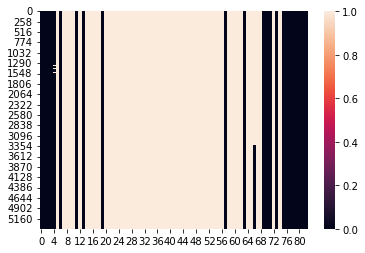

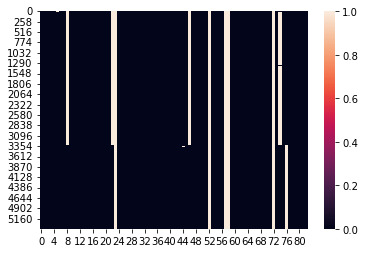

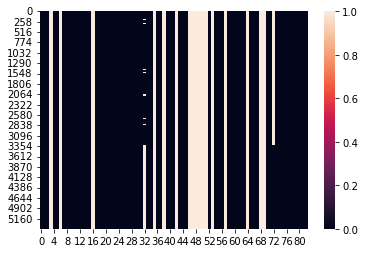

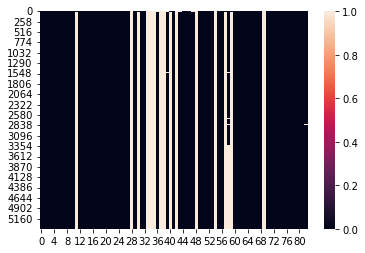

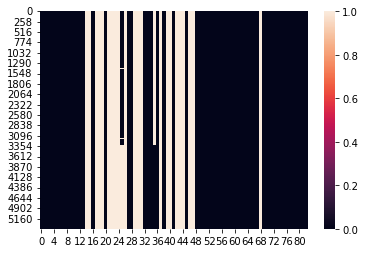

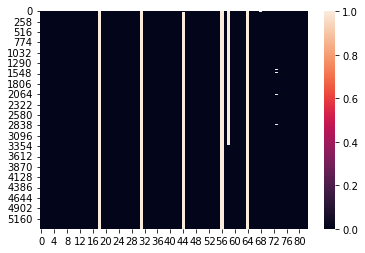

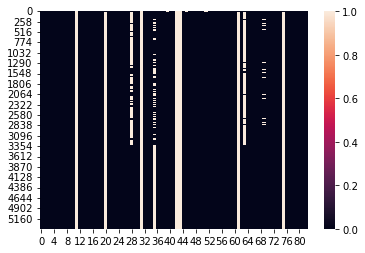

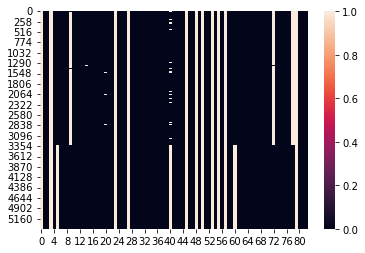

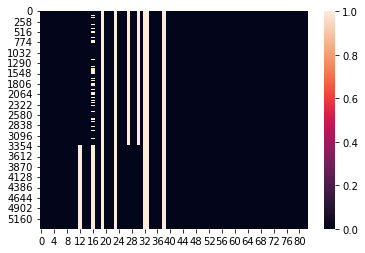

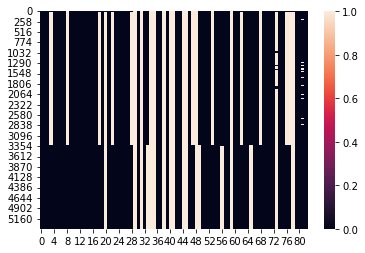

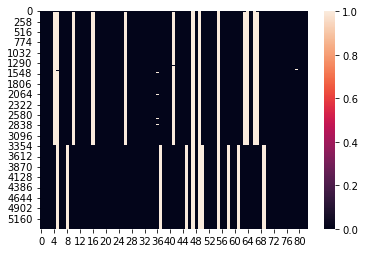

In [ ]:
for x in len(predict_test):
    fig, axes = plt.subplots(len(predict_test), )
    sns.heatmap(np.where(x[1] <= 0 , 0, 1))
    plt.show()

<AxesSubplot:>

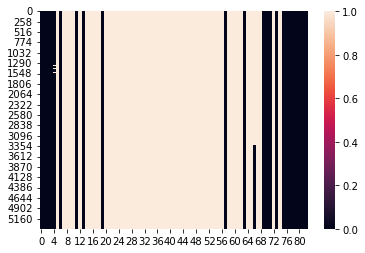

In [ ]:
sns.heatmap(np.where(predict_test[0][1] <= 0 , 0, 1))

<AxesSubplot:>

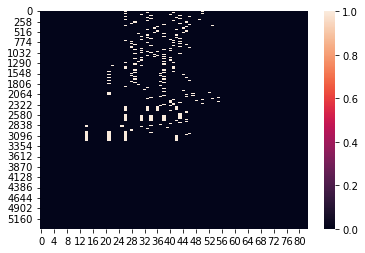

In [ ]:
sns.heatmap(test_set[1]['instrument_1'][1])